In [1]:
from google.colab import drive
drive.mount( '/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd gdrive/'My Drive'/GNR

/content/gdrive/My Drive/GNR


In [ ]:
!pip install jupyterthemes
!pip install livelossplot

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm 
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, LeakyReLU, LayerNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import math

n_adam = Nadam(lr=3e-4, epsilon=1e-7)

Tensorflow version: 2.3.0


In [57]:
  model = Sequential()

  # 1st Convolutional Layer
  model.add(Conv2D(filters=32, input_shape=(224,224,3), kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_uniform'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  # Max Pooling
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  # model.add(Dropout(0.1))


  # 2nd Convolutional Layer
  model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_uniform'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  # Max Pooling
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  # model.add(Dropout(0.1))

  # 3rd Convolutional Layer
  model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_uniform'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  # # Max Pooling
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  # model.add(Dropout(0.1))

  # 4th Convolutional Layer
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_uniform'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  # # Max Pooling
  model.add(MaxPooling2D(pool_size=(3,3), strides=(3,3), padding='valid'))
  # model.add(Dropout(0.1))

  # 5th Convolutional Layer
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  # Max Pooling
  model.add(MaxPooling2D(pool_size=(3,3), strides=(3,3), padding='valid'))
  # model.add(Dropout(0.1))

  # Passing it to a Fully Connected layer
  model.add(Flatten())
  # 1st Fully Connected Layer
  model.add(Dense(512, kernel_initializer='he_uniform'))
  model.add(LeakyReLU(alpha=0.05))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # 2nd Fully Connected Layer
  model.add(Dense(128, kernel_initializer='he_uniform'))
  model.add(LeakyReLU(alpha=0.05))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # Output Layer
  model.add(Dense(7, kernel_initializer='he_uniform'))
  model.add(Activation('softmax'))

  model.summary()

  # optimizer=SGD(learning_rate=0.0003)

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
leaky_re_lu_119 (LeakyReLU)  (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_119 (Bat (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
leaky_re_lu_120 (LeakyReLU)  (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization_120 (Bat (None, 112, 112, 64)    

In [ ]:
# train_X, train_Y = ImageDataGenerator().flow_from_directory("data/train2", target_size = (224, 224), class_mode='categorical', batch_size=7518).next()
# test_X = ImageDataGenerator().flow_from_directory("data/test", target_size = (224, 224), class_mode='categorical', batch_size=95, shuffle=False).next()[0]
# np.save("data/train2_X", train_X)
# np.save("data/train2_Y", train_Y)
# np.save("data/test_X", test_X)

In [6]:
train_X, train_Y, test_X = np.load('data/train2_X.npy'), np.load('data/train2_Y.npy'), np.load('data/test_X.npy')

In [7]:
test_Y = np.array([5,7,7,3,7,5,2,7,7,6,7,2,5,7,7,5,2,6,4,7,7,1,4,7,4,1,7,7,6,3,2,7,5,6,1,1,7,7,1,7,7,7,2,4,7,2,6,1,3,6,6,4,3,7,1,3,5,7,7,5,7,4,3,2,7,7,7,1,5,3,7,4,7,5,3,7,2,6,3,7,1,2,2,4,6,5,7,4,3,7,4,7,6,1,7])-1
test_Y = tf.keras.utils.to_categorical(test_Y, 7)

print(test_X.shape, test_Y.shape, sep="\n")

(95, 224, 224, 3)
(95, 7)


In [8]:
def preprocess_input(x):
    x /= 255.
    mean = [0.3794, 0.3961, 0.3725]
    std = [0.1846, 0.1853, 0.1804]

    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]

    x[..., 0] /= std[0]
    x[..., 1] /= std[1]
    x[..., 2] /= std[2]

    return x/2. # imagenet standard

In [9]:
train_X = preprocess_input(train_X)
test_X = preprocess_input(test_X)

In [24]:
import imgaug as ia
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Sometimes(0.3,iaa.GaussianBlur(sigma=(0, 0.1))),
    iaa.Sometimes(0.5, iaa.Sharpen()),
    iaa.PerspectiveTransform(scale=0.09)
], random_order=True)

def color_generator(batches, seq=seq):
    while True:
        batch_x, batch_y = next(batches)
        _batch_x = seq.augment_images(batch_x)
        yield (_batch_x, batch_y)

In [36]:
batch_size = 32
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow(train_X, train_Y, batch_size=batch_size)
# train_generator = color_generator(train_generator)
datagen_test = ImageDataGenerator()

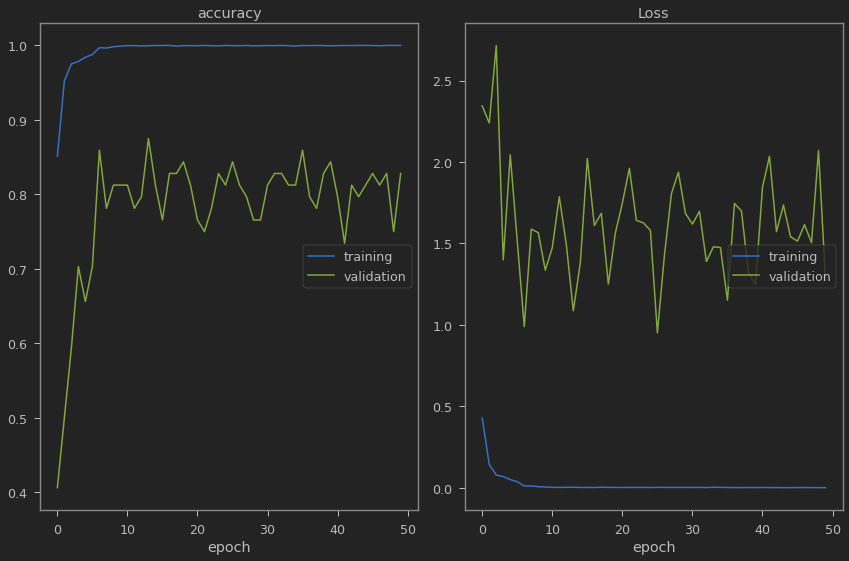

accuracy
	training         	 (min:    0.851, max:    1.000, cur:    1.000)
	validation       	 (min:    0.406, max:    0.875, cur:    0.828)
Loss
	training         	 (min:    0.001, max:    0.428, cur:    0.001)
	validation       	 (min:    0.951, max:    2.715, cur:    1.274)

Epoch 00050: val_accuracy did not improve from 0.87500
234/234 [==============================] - 24s 104ms/step - loss: 8.2116e-04 - accuracy: 1.0000 - val_loss: 1.2739 - val_accuracy: 0.8281


In [58]:
epochs = 50
steps_per_epoch = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size

checkpoint = ModelCheckpoint("model1_weights.h5", save_best_only = True, monitor='val_accuracy',
                            save_weights_only=True, mode='max', verbose=1)

def lr_decay(epoch):
	initial_lr = 0.01
	drop = 1/3
	epochs_drop = 10.0
	lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lr if not lr<0.000005 else 0.000005

# reduce_lr = LearningRateScheduler(lr_decay)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.00001, mode='auto')

callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = datagen_test.flow(test_X, test_Y, batch_size=batch_size),
    validation_steps=validation_steps,
    callbacks=callbacks)

In [65]:
predictions = np.argmax(model.predict(test_X), axis=-1)
true = np.argmax(test_Y, axis=-1)
np.mean(predictions==true)

0.8105263157894737

In [68]:
import pandas as pd
columns = ['ImageID', 'Label']
data = np.array([np.arange(1,96)+1000, (predictions+1)]).T
df = pd.DataFrame(data = data,   
                  columns = columns)
df.to_csv("predictions.csv", index=False)

In [ ]:
model1 = create_model()
model1.load_weights("model1_weights.h5")

predictions = np.argmax(model1.predict(test_X), axis=-1)
true = np.argmax(test_Y, axis=-1)
np.mean(predictions==true)

In [64]:
def create_model():
  model = Sequential()

  # 1st Convolutional Layer
  model.add(Conv2D(filters=32, input_shape=(224,224,3), kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_uniform'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  # Max Pooling
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  # model.add(Dropout(0.1))


  # 2nd Convolutional Layer
  model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_uniform'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  # Max Pooling
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  # model.add(Dropout(0.1))

  # 3rd Convolutional Layer
  model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_uniform'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  # # Max Pooling
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  # model.add(Dropout(0.1))

  # 4th Convolutional Layer
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_uniform'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  # # Max Pooling
  model.add(MaxPooling2D(pool_size=(3,3), strides=(3,3), padding='valid'))
  # model.add(Dropout(0.1))

  # 5th Convolutional Layer
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  # Max Pooling
  model.add(MaxPooling2D(pool_size=(3,3), strides=(3,3), padding='valid'))
  # model.add(Dropout(0.1))

  # Passing it to a Fully Connected layer
  model.add(Flatten())
  # 1st Fully Connected Layer
  model.add(Dense(512, kernel_initializer='he_uniform'))
  model.add(LeakyReLU(alpha=0.05))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # 2nd Fully Connected Layer
  model.add(Dense(128, kernel_initializer='he_uniform'))
  model.add(LeakyReLU(alpha=0.05))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # Output Layer
  model.add(Dense(7, kernel_initializer='he_uniform'))
  model.add(Activation('softmax'))

  # model.summary()

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
  return model

In [ ]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        # rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=10,
        shear_range=0.1,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        # brightness_range=[0.8,1.2],
        fill_mode='constant'
        )

classes = ['1_basketball_court', '2_beach', '3_forest', '7_others', '4_railway', '6_swimming_pool', '5_tennis_court']

for cls in classes:
  for filename in tqdm(os.listdir("/content/gdrive/My Drive/GNR/data/train/"+cls)):
    img = load_img("/content/gdrive/My Drive/GNR/data/train/"+cls+"/"+filename)  
    x = img_to_array(img) 
    x = x.reshape((1,) + x.shape) 

    i = 0
    limit = 10
    if cls in ['1_basketball_court', '2_beach']:
      limit = 15
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir="/content/gdrive/My Drive/GNR/data/train2/"+cls, save_prefix=filename, save_format='jpeg', ):
        i += 1
        if i > limit:
            break

100%|██████████| 80/80 [00:25<00:00,  3.16it/s]


In [ ]:
import shutil

shutil.copytree("/content/gdrive/My Drive/GNR/data/train/", "/content/gdrive/My Drive/GNR/data/train2/")

'/content/gdrive/My Drive/GNR/data/train2/'

In [ ]:
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier

In [ ]:
def my_model():
  return model
ann_estimator = KerasClassifier(build_fn= my_model, epochs=20, batch_size=32, verbose=0)

In [ ]:
boosted_ann = AdaBoostClassifier(base_estimator= ann_estimator)
boosted_ann.fit(tr_X, train_Y)